# Deep Learning Tensorflow/Keras approach 
    -> Ressources: 
    https://towardsdatascience.com/building-a-multi-output-convolutional-neural-network-with-keras-ed24c7bc1178
    https://keras.io/guides/functional_api/
    (Multi-Output-Network)

# NN with single-input-single-output

In [10]:
import pandas as pd

df = pd.read_csv("../static_merged_data.csv")
df.head()


,T_min,T_max,T_delta,Pow_mean,status
0,24.559295,27.063301,2.504006,0.0,drossel
1,24.559295,27.063301,2.504006,0.0,drossel
2,24.559295,27.063301,2.504006,0.0,drossel
3,24.559295,27.063301,2.504006,0.0,drossel
4,24.559295,27.063301,2.504006,0.0,drossel


In [11]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# devide it into labels and features
Y = df[["status"]]
X = df[["T_min","T_max","T_delta","Pow_mean"]]

# split the dataset into train- and testset
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=.2)

#y_categ = to_categorical(Y,3) #does not work: only integers
y_train.head()

,status
76238,normal
75755,normal
62355,mosfets
71140,normal
18557,drossel


In [12]:
from keras.utils import to_categorical
pd_series_nums = y_train.status.astype('category').cat.codes.to_numpy()
labels = to_categorical(pd_series_nums, 3)
labels.shape

(77079, 3)

In [13]:
X_numpy = X_train.to_numpy()
#X_numpy.resize(96349,1,4)
X_numpy.shape

(77079, 4)

In [14]:
def prepare_train_test_set(X, Y, num_classes):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=.2)
    train_labels = y_train.status.astype('category').cat.codes.to_numpy()
    test_labels = y_test.status.astype('category').cat.codes.to_numpy()
    train_labels = to_categorical(train_labels, num_classes)
    test_labels = to_categorical(test_labels, num_classes)
    X_train.to_numpy()
    X_test.to_numpy()
    return (X_train, X_test), (train_labels, test_labels)

In [15]:
(X_train, X_test), (train_labels, test_labels) = prepare_train_test_set(X,Y,3)

In [60]:
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
import tensorflow as tf
from keras import Sequential
from keras.layers import Activation 

model = Sequential([
    Input(shape=(4,), name="input-layer"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(16, activation="relu"),
    Dense(3, activation="softmax", name="output_layer")
], name="DCDC_type_classifier")

model.summary()

Model: "DCDC_type_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 64)                320       
                                                                 
 dense_57 (Dense)            (None, 64)                4160      
                                                                 
 dense_58 (Dense)            (None, 64)                4160      
                                                                 
 dense_59 (Dense)            (None, 16)                1040      
                                                                 
 output_layer (Dense)        (None, 3)                 51        
                                                                 
Total params: 9,731
Trainable params: 9,731
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=["acc"])

history = model.fit(X_train, train_labels, 256, 50, validation_split=0.1)

Epoch 1/50
271/271 [==============================] - 1s 3ms/step - loss: 1.0880 - acc: 0.4275 - val_loss: 0.9787 - val_acc: 0.4299
Epoch 2/50
271/271 [==============================] - 1s 2ms/step - loss: 0.9381 - acc: 0.5252 - val_loss: 0.8835 - val_acc: 0.6341
Epoch 3/50
271/271 [==============================] - 1s 2ms/step - loss: 0.8332 - acc: 0.6151 - val_loss: 0.7592 - val_acc: 0.6142
Epoch 4/50
271/271 [==============================] - 1s 2ms/step - loss: 0.6939 - acc: 0.7129 - val_loss: 0.6033 - val_acc: 0.7999
Epoch 5/50
271/271 [==============================] - 1s 2ms/step - loss: 0.5585 - acc: 0.7900 - val_loss: 0.4688 - val_acc: 0.8478
Epoch 6/50
271/271 [==============================] - 1s 2ms/step - loss: 0.4406 - acc: 0.8527 - val_loss: 0.4940 - val_acc: 0.7682
Epoch 7/50
271/271 [==============================] - 1s 2ms/step - loss: 0.3841 - acc: 0.8575 - val_loss: 0.3388 - val_acc: 0.8821
Epoch 8/50
271/271 [==============================] - 1s 2ms/step - loss: 0.

In [18]:
import matplotlib.pyplot as plt


# function for plotting the history including validation/training loss and accuracy
def plot_history(history, epochs_size):
    loss = history.history["loss"]
    accuracy = history.history["acc"]
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_acc"]
    # max_acc = accuracy[np.argmax(accuracy)]
    # max_val_acc = val_accuracy[np.argmax(val_accuracy)]
    epochs = range(1, (epochs_size+1))
    ig, ax = plt.subplots(2, figsize=(20, 8))
    ax[0].plot(epochs ,loss, "b", label="Training loss")
    ax[0].plot(epochs, val_loss, "r", label="Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()
    ax[1].plot(epochs, accuracy, "g", label="Training accuracy")
    ax[1].plot(epochs, val_accuracy, "y", label="Validation accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()
    

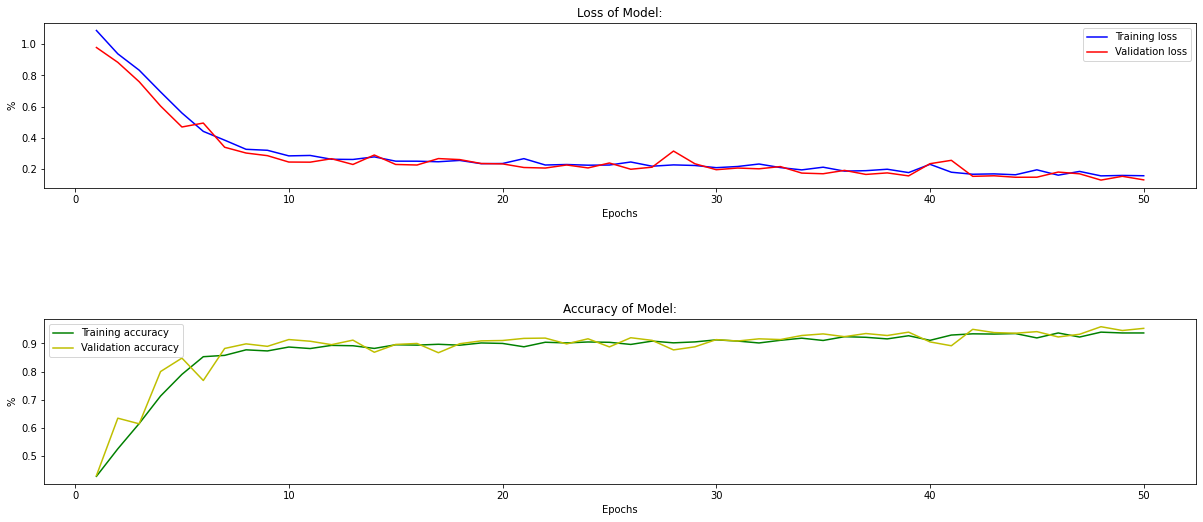

In [27]:
plot_history(history=history, epochs_size=50)

# NN with single-input-multi-output

In [36]:
df_audio = pd.read_csv("../audio_merged_data.csv")
df_audio.head()

,T_min,T_max,T_delta,Pow_mean,status,songtitle
0,24.058494,26.562500,2.504006,18.992137,drossel,neelix
1,24.308894,26.812901,2.504006,19.233031,drossel,neelix
2,24.308894,26.812901,2.504006,19.135991,drossel,neelix
3,24.308894,26.812901,2.504006,19.350136,drossel,neelix
4,24.308894,26.812901,2.504006,19.545401,drossel,neelix


In [47]:
X_audio = df_audio[["T_min", "T_max", "T_delta", "Pow_mean"]]
y_audio = df_audio[["status", "songtitle"]]

def prepare_multi_output_train_test_set(X, Y, num_converters, num_songs):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=.2)
    conv_train_labels = y_train.status.astype('category').cat.codes.to_numpy()
    conv_test_labels = y_test.status.astype('category').cat.codes.to_numpy()
    song_train_labels = y_train.songtitle.astype('category').cat.codes.to_numpy()
    song_test_labels = y_test.songtitle.astype('category').cat.codes.to_numpy()
    conv_train_labels = to_categorical(conv_train_labels, num_converters)
    conv_test_labels = to_categorical(conv_test_labels, num_converters)
    song_train_labels = to_categorical(song_train_labels, num_songs)
    song_test_labels = to_categorical(song_test_labels, num_songs)
    X_train.to_numpy()
    X_test.to_numpy()
    return (X_train, X_test), (conv_train_labels, conv_test_labels), (song_train_labels, song_test_labels)
(X_train, X_test), (conv_train_labels, conv_test_labels), (song_train_labels, song_test_labels) = prepare_multi_output_train_test_set(X_audio, y_audio, 3, 3)

In [48]:
class ConverterClassifier():
    
    def make_default_hidden_layers(self, inputs):
        x = Dense(64)(inputs)
        x = Activation("relu")(x)
        x = Dense(32)(x)
        x = Activation("relu")(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        return x

    def build_converter_branch(self, inputs, num_of_converters):
        x = self.make_default_hidden_layers(inputs)
        x = Dense(num_of_converters)(x)
        x = Activation("softmax", name="converter_output")(x)
        return x

    def build_song_branch(self, inputs, num_of_songs):
        x = self.make_default_hidden_layers(inputs)
        x = Dense(num_of_songs)(x)
        x = Activation("softmax", name="song_output")(x)
        return x

    def assemble_full_model(self, input_shape, num_converters, num_songs):
        """
        Used to assemble our multi-output model CNN.
        """
        inputs = Input(shape=input_shape)
        converter_branch = self.build_converter_branch(inputs, num_converters)
        song_branch = self.build_song_branch(inputs, num_songs)
        model = Model(inputs=inputs,
                     outputs = [converter_branch, song_branch],
                     name="converter_net")
        return model

In [61]:
model = ConverterClassifier().assemble_full_model((4,), num_converters=3, num_songs=3)

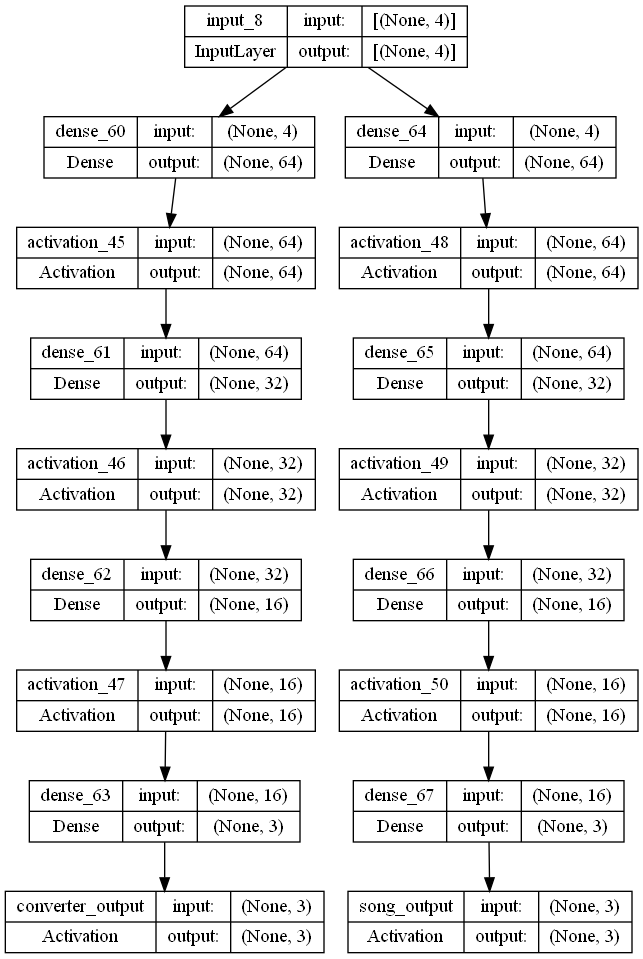

In [62]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [63]:
from keras.optimizers import Adam
init_lr = 1e-4
epochs = 40
opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'converter_output': 'categorical_crossentropy', 
                  'song_output': 'categorical_crossentropy'},
    
              metrics={
                  'converter_output': 'accuracy',
                  'song_output': 'accuracy'})

In [64]:
history = model.fit(X_train, [conv_train_labels, song_train_labels], batch_size=128, epochs=epochs, validation_split=.1)

Epoch 1/40
49/49 [==============================] - 1s 8ms/step - loss: 4.4180 - converter_output_loss: 2.6664 - song_output_loss: 1.7516 - converter_output_accuracy: 0.2933 - song_output_accuracy: 0.3678 - val_loss: 2.9057 - val_converter_output_loss: 2.0021 - val_song_output_loss: 0.9037 - val_converter_output_accuracy: 0.3060 - val_song_output_accuracy: 0.5489
Epoch 2/40
49/49 [==============================] - 0s 2ms/step - loss: 2.5437 - converter_output_loss: 1.7033 - song_output_loss: 0.8404 - converter_output_accuracy: 0.2830 - song_output_accuracy: 0.5966 - val_loss: 2.2413 - val_converter_output_loss: 1.4445 - val_song_output_loss: 0.7969 - val_converter_output_accuracy: 0.2802 - val_song_output_accuracy: 0.6164
Epoch 3/40
49/49 [==============================] - 0s 3ms/step - loss: 2.1195 - converter_output_loss: 1.3396 - song_output_loss: 0.7799 - converter_output_accuracy: 0.2921 - song_output_accuracy: 0.6033 - val_loss: 2.0527 - val_converter_output_loss: 1.2877 - val_so

In [114]:
loss_list = []
accuracy_list = []
history_keys = history.history.keys()
for key in history_keys:
    if "loss" in key:
        loss_list.append(key)
    
    elif "accuracy" in key:
        accuracy_list.append(key)

print(loss_list)
print(accuracy_list)


['loss', 'converter_output_loss', 'song_output_loss', 'val_loss', 'val_converter_output_loss', 'val_song_output_loss']
['converter_output_accuracy', 'song_output_accuracy', 'val_converter_output_accuracy', 'val_song_output_accuracy']


In [117]:
import matplotlib.colors as mcolors

def plot_history(history, epochs_size):
    colors = list(mcolors.BASE_COLORS.keys())
    epochs = range(1, (epochs_size+1))
    ig, ax = plt.subplots(2, figsize=(20, 8))

    for key,color in zip(loss_list, colors):
        ax[0].plot(epochs ,history.history[key], str(color), label=str(key))

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()

    for key,color in zip(accuracy_list, colors):
        ax[1].plot(epochs, history.history[key], str(color), label=str(key))
        
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()

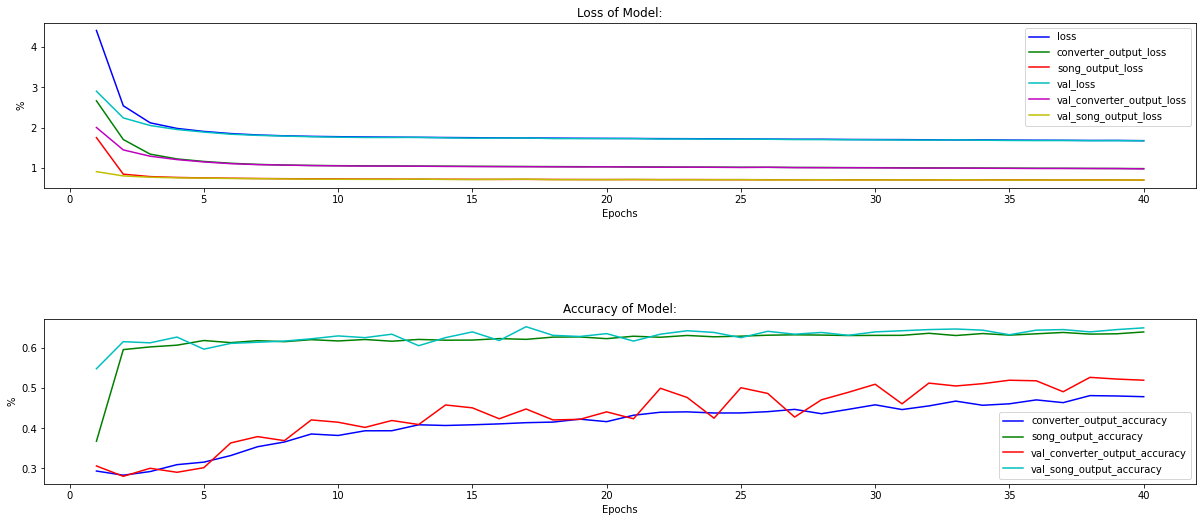

In [118]:
plot_history(history, 40)